# **Project 3: Hamburger/Hotdog**: Model 5: Additional Layers, Increasing Neurons, Adding Batch Normalization Layers, Early Stopping & Dropout


## **Import the necessary libraries**

In [86]:
from PIL import Image
import pandas as pd
import requests
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow modules
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam


# scikit-learn modules
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Library for randomly selecting data points
import random

from Utils import plot_training_history, evaluate_model, plot_confusion_matrix

## **Load and Prepare the Dataset**

- Load and standardize the dataset
- Extract and encode lables.
- Split the data into the train and the test dataset.

In [87]:
# Function to Load Images and Labels
# This function walks through the directory structure, loads the images, converts them into a consistent format,
# resizes them as needed and extracts labels from the directory names:

def load_images_from_folder(folder, count, img_size=(256, 256)):
    images = []
    for idx, filename in enumerate(os.listdir(folder)):
        if idx >= count:  # Only load up to 'count' images
            break
        if filename.endswith('.jpg'):
            img_path = os.path.join(folder, filename)
            with Image.open(img_path) as img:
                img = img.convert('RGB')  # Convert to RGB
                img = img.resize(img_size)  # Resize the image
                images.append(np.array(img))
    return np.array(images)

In [88]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [89]:
# Load Images and Create Labels
#hotdog_folder = '/content/hamburger_images'
#hamburger_folder = '/content/hotdog_images'

hotdog_folder = "/content/drive/MyDrive/IMAGES/HOTDOG_SOURCE"
hamburger_folder = "/content/drive/MyDrive/IMAGES/HAMBURGER_SOURCE"

# Load images
hotdog_images = load_images_from_folder(hotdog_folder,1000)
hamburger_images = load_images_from_folder(hamburger_folder,1000)

# Create labels (zeros and ones for the hotdog and notdog images)
hotdog_labels = np.ones(len(hotdog_images))
hamburger_labels = np.zeros(len(hamburger_images))

# Combine images and labels
X = np.concatenate((hotdog_images, hamburger_images), axis=0)
y = np.concatenate((hotdog_labels, hamburger_labels), axis=0)

In [90]:
print(len(hamburger_images))
print(len(hotdog_images))

1000
1000


In [91]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## **Visualizing images**

- Use X_train to visualize the first 10 images.
- Use Y_train to print the first 10 labels.

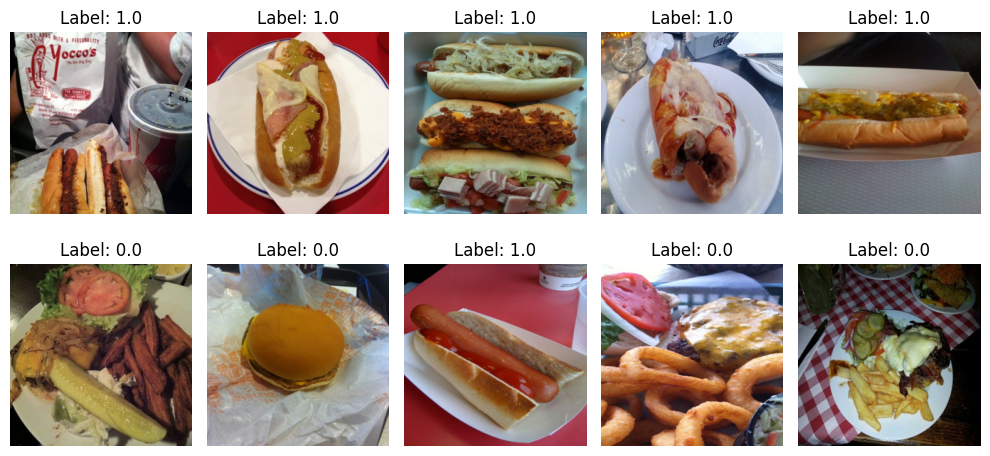

In [92]:
# Visualize the first 10 images in the dataset and printing their classification labels

def plot_images(images, labels, num_images=10):
    # Set up the figure size in inches
    plt.figure(figsize=(10, 5))

    for i in range(num_images):
        # Create a subplot for each image
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')  # Turn off axis numbering

    plt.tight_layout()
    plt.show()

plot_images(X_train, y_train)


## **Data preparation**
- Normalize the train and the test dataset by dividing by 255.

In [93]:
# Normalizing the image pixel inputs
X_train = X_train / 255.0
X_test = X_test / 255.0

In [94]:
# Displaying the first normalized training image
print('Test Dataset:', X_test.shape, y_test.shape)
print('Training Dataset:', X_train.shape, y_train.shape)

Test Dataset: (400, 256, 256, 3) (400,)
Training Dataset: (1600, 256, 256, 3) (1600,)


In [95]:
# Displaying the first normalized testing image and its pixel values
print("Shape of the first normalized testing image:", X_test[0].shape)
print("Pixel values of the first normalized testing image:")
print(X_test[0])

Shape of the first normalized testing image: (256, 256, 3)
Pixel values of the first normalized testing image:
[[[0.6        0.11764706 0.26666667]
  [0.58431373 0.10588235 0.25098039]
  [0.58039216 0.10980392 0.25882353]
  ...
  [0.6        0.81176471 0.98431373]
  [0.6        0.82352941 0.99215686]
  [0.6        0.83137255 0.99607843]]

 [[0.49019608 0.07058824 0.21960784]
  [0.47843137 0.0627451  0.20784314]
  [0.46666667 0.0627451  0.20784314]
  ...
  [0.60392157 0.81568627 0.98823529]
  [0.60392157 0.82745098 0.99607843]
  [0.60392157 0.83137255 1.        ]]

 [[0.35686275 0.04313725 0.19215686]
  [0.35294118 0.04705882 0.19215686]
  [0.34901961 0.05098039 0.19215686]
  ...
  [0.60784314 0.81960784 0.99215686]
  [0.60784314 0.83529412 0.99607843]
  [0.60784314 0.83921569 0.99607843]]

 ...

 [[0.04705882 0.04705882 0.08627451]
  [0.04313725 0.04313725 0.09019608]
  [0.04313725 0.04313725 0.09019608]
  ...
  [0.07843137 0.03921569 0.07058824]
  [0.05882353 0.05490196 0.06666667]
  

# Model Building

In [96]:
# Apply augmentation to the whole training dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=20,      # Random rotation (degrees)
    width_shift_range=0.1,  # Random horizontal shift
    height_shift_range=0.1, # Random vertical shift
    shear_range=0.2,        # Shear intensity
    zoom_range=0.2,         # Random zoom
    horizontal_flip=True,   # Random horizontal flip
    vertical_flip=False,    # No vertical flip for face images
    fill_mode='nearest'     # Fill mode for handling newly created pixels
)

# Create variables to hold the X and y training data
X_train_aug = []
y_train_aug = []

# Loop through all the images.
for i in range(len(X_train)):
    # Select the image
    img = X_train[i]
    # Select the label from the training data
    label = y_train[i]

    # Ensure that the input data has the correct shape (Add batch dimension)
    img = np.expand_dims(img, axis=0)

    # Create the iterator
    it = datagen.flow(img, batch_size=1)

    # Add 5 augmented images for every original image
    for j in range(5):
        # Append a new image to the X list
        X_train_aug.append(next(it)[0])  # Correctly use next() with the iterator
        # Append the label for the original image to the y list
        y_train_aug.append(label)

# Print the length of each list
print(len(X_train_aug))
print(len(y_train_aug))


8000
8000


In [97]:
# Convert lists to numpy arrays
X_train_aug = np.array(X_train_aug)
y_train_aug = np.array(y_train_aug)

# Ensure X_train_aug is a 4D array and y_train_aug is a 1D array
print("X_train_aug shape:", X_train_aug.shape)
print("y_train_aug shape:", y_train_aug.shape)


X_train_aug shape: (8000, 256, 256, 3)
y_train_aug shape: (8000,)


### **CNN Model - Iteration #5**

### Additional Layers, Increasing Neurons, Adding Batch Normalization Layers, Early Stopping & Dropout

In [98]:
### Fix the seed for random number generators
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [99]:
# Define a CNN model
model_5 = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])
# Compile the model
model_5.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [100]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',   # Monitor validation loss
    patience=3,           # Number of epochs with no improvement after which training will be stopped
    verbose=1,            # Verbosity mode
    restore_best_weights=True  # Restores model weights from the epoch with the lowest validation loss
)

# Fit the model with early stopping
history_5 = model_5.fit(
    X_train_aug, y_train_aug,
    validation_data=(X_test, y_test),
    epochs=10,
    callbacks=[early_stopping]
)

Epoch 1/10
250/250 [==============================] - 25s 86ms/step - loss: 3.0859 - accuracy: 0.5832 - val_loss: 9.5957 - val_accuracy: 0.5025
Epoch 2/10
250/250 [==============================] - 21s 83ms/step - loss: 0.6689 - accuracy: 0.6294 - val_loss: 1.2652 - val_accuracy: 0.5675
Epoch 3/10
250/250 [==============================] - 21s 83ms/step - loss: 1.0748 - accuracy: 0.6206 - val_loss: 0.7900 - val_accuracy: 0.5775
Epoch 4/10
250/250 [==============================] - 21s 83ms/step - loss: 0.6158 - accuracy: 0.6403 - val_loss: 0.5938 - val_accuracy: 0.6725
Epoch 5/10
250/250 [==============================] - 21s 82ms/step - loss: 0.5765 - accuracy: 0.6621 - val_loss: 0.6117 - val_accuracy: 0.6875
Epoch 6/10
250/250 [==============================] - 21s 82ms/step - loss: 0.5327 - accuracy: 0.6935 - val_loss: 0.6304 - val_accuracy: 0.6800
Epoch 7/10
250/250 [==============================] - 21s 83ms/step - loss: 0.5009 - accuracy: 0.7160 - val_loss: 0.8981 - val_accuracy:

In [101]:
# Evaluating on the Test dataset
evaluate_model(model_5, X_test, y_test)

13/13 [==============================] - 0s 20ms/step - loss: 0.5938 - accuracy: 0.6725
Test Loss: 0.5937654376029968
Test Accuracy: 0.6725000143051147


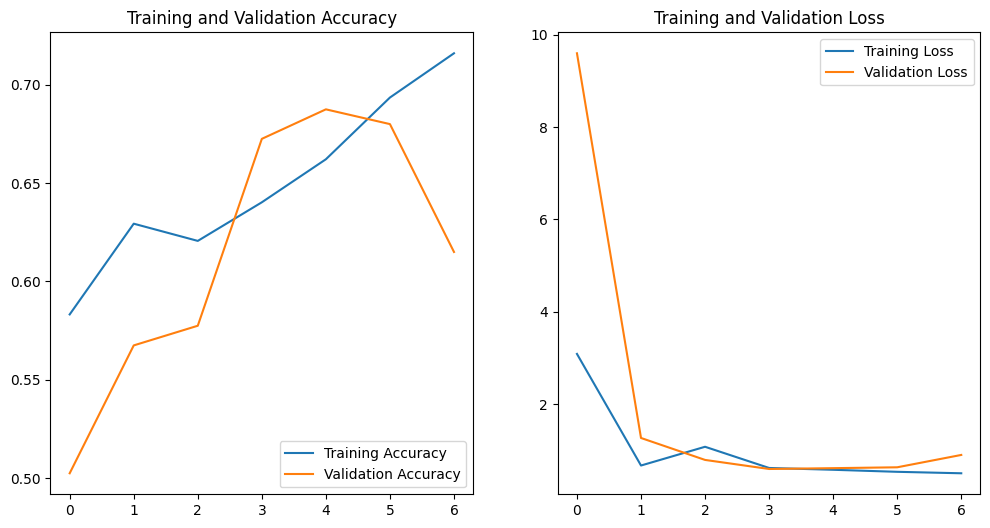

In [102]:
# Accuracy and Loss Plots
plot_training_history(history_5)

In [103]:
# Make Predictions
y_pred = model_5.predict(X_test)

# Convert probabilities to binary labels based on a 0.5 threshold
y_pred_labels = (y_pred > 0.5).astype(int)

13/13 [==============================] - 0s 19ms/step


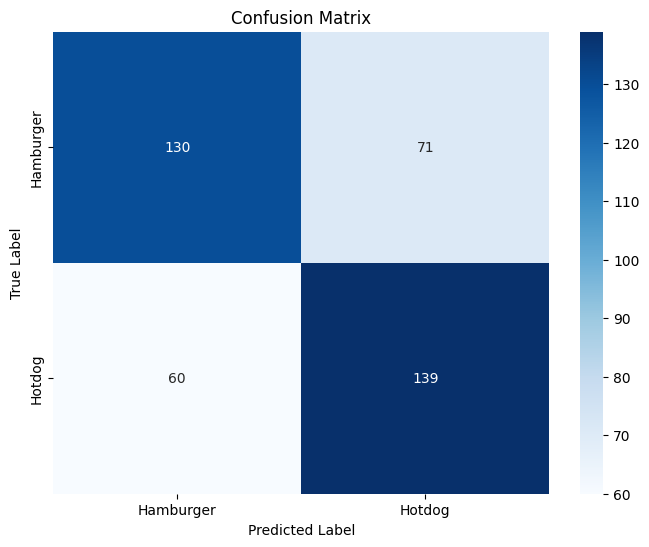

In [104]:
# Plot Confusion Matrix
plot_confusion_matrix(y_test, y_pred_labels,['Hamburger', 'Hotdog'])

## Save the Trained Model

In [105]:
from pathlib import Path
# Set the model's file path
file_path = Path("/content/drive/MyDrive/IMAGES/CNN_Model_5.keras")

# Export your model
model_2.save(file_path)

## Loading a Trained Model

In [106]:
# Load the model to a new object
model_5_imported = tf.keras.models.load_model(file_path)

### Gradio App

In [107]:
!pip install gradio
import gradio as gr

def classify_image(image):
    # Resize the image to match the input shape of the model
    image = tf.image.resize(image, (256, 256))
    # Scale image pixels to 0-1
    image = image / 255.0
    image = np.expand_dims(image, axis=0)  # Add batch dimension

    # Predict
    prediction = model_5.predict(image)[0][0]

    # Convert prediction to label
    label = "Hotdog" if prediction > 0.5 else "Hamburger"
    return label

# Adjust Gradio interface accordingly
iface = gr.Interface(
    fn=classify_image,
    inputs=gr.Image(),
    outputs="text",
    title="Hamburger or Hotdog Classifier",
    description="Upload an image to see if it's a hamburger or hotdog."
)

# Launch the interface
iface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://b9e16363eaff5c1646.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
